# Train a RESNET model on the esc50 dataset

## Imports

In [2]:
# change working directory to the root of the project
import os
os.chdir("../")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /workspaces/GADME


In [3]:
# imports
from omegaconf import OmegaConf
import torchvision
import torch
import torchmetrics.classification

from src.modules.base_module import BaseModule
from src.datamodule.esc50_datamodule import ESC50
from src.utils.ast_extractor import CustomASTFeatureExtractor


## Datamodule

In [17]:
esc50_config = OmegaConf.create({
    "dataset": {
        "data_dir": "/workspaces/GADME/data",
        "dataset_name": "esc50",
        "hf_path": "ashraq/esc50",
        "hf_name": None,
        "seed": 42,
        "feature_extractor": {
            "_target_": 'src.utils.ast_extractor.CustomASTFeatureExtractor',
            "n_classes": 50,
            "n_workers": 1,
            "column_list": ["input_values", "target"],
            "val_split": 0.2,
            "sampling_rate": 32000,
            "return_tensor": 'pt',
        },
        "n_classes": 50,
        "n_workers": 16,
        "column_list": ["input_values", "target"],
        "val_split": 0.2,
    },
    "loaders": {
        "train": {
            "batch_size": 128,
            "shuffle": True,
            "num_workers": 32,
            "drop_last": False,
            "pin_memory": False
        },
        "valid": {
            "batch_size": 128,
            "shuffle": False,
            "num_workers": 32,
            "drop_last": False,
            "pin_memory": False
        },
        "test": {
            "batch_size": 6,
            "shuffle": False,
            "num_workers": 4,
            "drop_last": False,
            "pin_memory": False
        },
    },
    "transforms": {
        "use_channel_dim": False,
        "normalize": True,
        "use_spectrogram": True,
        "n_fft": 1024,
        "hop_length": 79,
        "n_mels": 128,
        "db_scale": True,
        "target_height": 32,
        "target_width": 32,
        "waveform_augmentations": {
            "colored_noise": {
                "prob": 0.5,
                "min_snr_in_db": 3.0,
                "max_snr_in_db": 30.0,
                "min_f_decay": -2.0,
                "max_f_decay": 2.0
            },
        },
        "spectrogram_augmentations": {
            "time_masking": {
                "time_mask_param": 100,
                "prob": 0.5
            },
            "frequency_masking": {
                "freq_mask_param": 100,
                "prob": 0.5
            },
            "time_stretch": {
                "prob": 0.5,
                "min_rate": 0.8,
                "max_rate": 1.2
            },
        },
    },
})

In [18]:
esc50_datamodule = ESC50(dataset=esc50_config.dataset, loaders=esc50_config.loaders, transforms=esc50_config.transforms)

In [6]:
esc50_datamodule.prepare_data()

Repo card metadata block was not found. Setting CardData to empty.


In [45]:
esc50_datamodule.setup(stage="fit") 

In [46]:
train_dataloader = esc50_datamodule.train_dataloader()
batch = next(iter(train_dataloader))

In [47]:
batch

(tensor([[[[-3.8527, -3.9735, -4.2276,  ..., -5.1062, -5.1062, -5.1062],
           [-3.2676, -3.3885, -3.6425,  ..., -4.8009, -4.7123, -4.8226],
           [-5.1062, -3.8351, -3.3042,  ..., -3.2593, -3.2996, -3.3942],
           ...,
           [-3.1246, -3.0223, -2.8535,  ..., -3.6693, -3.8878, -4.1237],
           [-3.1658, -3.1461, -3.1157,  ..., -3.9745, -3.9012, -3.8259],
           [-3.2888, -3.3467, -3.5316,  ..., -3.9717, -3.9632, -4.0572]]],
 
 
         [[[-4.1841, -4.1800, -3.9135,  ..., -3.2461, -2.7151, -2.4202],
           [-3.5990, -3.5949, -3.3285,  ..., -2.6610, -2.1300, -1.8351],
           [-3.7290, -3.5733, -3.2701,  ..., -2.9683, -3.0861, -2.3946],
           ...,
           [-2.8210, -1.9241, -1.3246,  ..., -1.6116, -1.4023, -1.2282],
           [-1.4854, -1.4314, -1.3282,  ..., -1.7946, -1.9609, -2.0002],
           [-1.4850, -1.5332, -1.6557,  ..., -1.2432, -1.2595, -1.0633]]],
 
 
         [[[ 0.5111,  0.4707,  0.3381,  ..., -0.9272, -1.1783, -1.6288],
       

In [48]:
batch[0].shape

torch.Size([6, 1, 32, 32])

In [49]:
batch[1].shape

torch.Size([6])

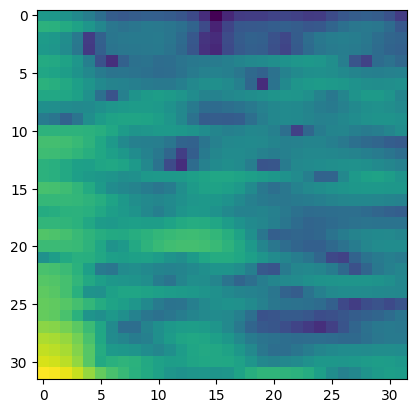

In [51]:
# plot the first spectrogram
import matplotlib.pyplot as plt
plt.imshow(batch[0][2].squeeze().numpy())


## Lightning Module

In [40]:
module_config = OmegaConf.create({
    "network": {
        "model_name": "resnet50",
        "model": {
            "_target_": 'torchvision.models.resnet50',
            "weights": 'ResNet50_Weights.IMAGENET1K_V1'
        },
        "torch_compile": False
    },
    "output_activation": {
        "_target_": 'torch.softmax',
        "dim": 1
    },
    "loss": {
        "_target_": 'torch.nn.CrossEntropyLoss'
    },
    "optimizer": {
        "_target_": 'torch.optim.Adam',
        "lr": 0.001,
        "weight_decay": 0.01
    },
    "lr_scheduler": {
        "_target_": 'torch.optim.lr_scheduler',
    },
    "metrics": {
        "main": {
            "_target_": 'torchmetrics.classification.Accuracy',
            "task": "multiclass",
            "num_classes": 50,
            "top_k": 1,
        },
        "val_best": {   
            "_target_": 'torchmetrics.MaxMetric',
        }
    },
    "num_epochs": 200,
    "logging_params": None,
    "len_trainset": 50000
})

In [41]:
resnetModule = BaseModule(
    network=module_config.network,
    output_activation= module_config.output_activation,
    loss=module_config.loss,
    optimizer=module_config.optimizer,
    lr_scheduler=module_config.lr_scheduler,
    metrics=module_config.metrics,
    logging_params=module_config.logging_params,
    num_epochs=module_config.num_epochs,
    len_trainset=module_config.len_trainset
)
    

In [42]:
resnetModule

BaseModule(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [19]:
from src.modules.models.benchmark_models import LightningResNet, ResNetVersion
resnetModule = LightningResNet(
    baseline_architecture='resnet18',
    num_classes=50,
    num_channels=1,
    learning_rate=0.001,
    pretrained=False,
)

In [20]:
resnetModule

LightningResNet(
  (criterion): CrossEntropyLoss()
  (acc): MulticlassAccuracy()
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

## Training

In [21]:
from lightning import Trainer
trainer = Trainer(max_epochs=200, devices=1)
trainer.fit(resnetModule, esc50_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Repo card metadata block was not found. Setting CardData to empty.


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name      | Type               | Params
-------------------------------------------------
0 | criterion | CrossEntropyLoss   | 0     
1 | acc       | MulticlassAccuracy | 0     
2 | model     | ResNet             | 11.2 M
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.784    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [16]:
trainer.test(resnetModule, esc50_datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.03999999910593033    │
│         test_loss         │     4.186829090118408     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.186829090118408, 'test_acc': 0.03999999910593033}]